In [1]:
import pandas as pd
import math

from os.path import join
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import altair as alt
import plotly.graph_objs as go

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Load Data

In [2]:
aos_sensors = ['APPUSAGE', 'CALL', 'GRAVITY', 'KEYSTROKE', 'LIGHT', 'LOCATION', 'NOTIFICATIONS', 'SCREEN_STATE', 'SIGNIFICANT_MOTION', 'SOUND', 'STEP', 'TYPING']
aos_path = r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\Code_stdd\aos_data'
aos_pids = [128, 644, 262, 391, 648, 139, 14, 400, 276, 21, 280, 408, 411, 797, 30, 543, 36, 553, 57, 63, 193, 67, 72, 713, 202, 337, 83, 599, 221, 741, 360, 624, 118, 119, 758] 
aos_pids.sort()

In [13]:
aos_survey = pd.read_csv('aos_data/aos_survey.csv', index_col=0)
aos_survey['timestamp'] = pd.to_datetime(aos_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema = aos_survey[['pid', 'timestamp','depressed']]
aos_ema.set_index(['pid', 'timestamp'], inplace=True)

dataset_list = list()
for interval in range(4, 25, 4):
    df_list = list()
    dataset = pd.DataFrame()

    for sensor in aos_sensors:
        aos_file = join(aos_path,'aos_{}_{}HR.csv'.format(sensor, interval))
        df = pd.read_csv(aos_file, index_col = 0)
        pids = df.index
        df.reset_index(inplace=True)
        df_list.append(df)

    dataset = pd.concat(df_list, axis=1)
    dataset.drop(['pid','timestamp'], axis=1, inplace=True)
    dataset.index = aos_ema.index
    dataset_list.append(dataset)

In [4]:
'''aos_survey_12 = aos_survey.copy()
conditions = [aos_survey_12['phq'] < 12, aos_survey_12['phq'] >= 12]
choices = [0, 1]
aos_survey_12["depressed"] = np.select(conditions, choices, default=np.nan)

aos_survey_12['timestamp'] = pd.to_datetime(aos_survey_12['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema_12 = aos_survey_12[['pid', 'timestamp','depressed']]
aos_ema_12.set_index(['pid', 'timestamp'], inplace=True)

ema_list = list()
for i in range(10):
    sur = aos_survey.copy()
    conditions = [sur['phq'] < 10+i, sur['phq'] >= 10+i]
    choices = [0, 1]
    sur["depressed"] = np.select(conditions, choices, default=np.nan)

    sur['timestamp'] = pd.to_datetime(sur['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    aos_ema = sur[['pid', 'timestamp','depressed']]
    aos_ema.set_index(['pid', 'timestamp'], inplace=True)
    ema_list.append(aos_ema)'''

In [14]:
def normalize_dataframe(dataset):
    df_list = list()
    for pid in aos_pids:
        df = dataset.loc[pid]
        for column in df.columns:
            cMin, cMax = df[column].min(), df[column].max()
            if (cMax-cMin) == 0:
                df.drop(columns=[column], inplace=True)
            else:
                df[column] = df[column].apply(lambda x: (x-cMin)/(cMax-cMin))      
        df_list.append(df)                 
    
    dataset = pd.concat(df_list)
    dataset.reset_index()
    dataset.index = aos_ema.index
    return dataset

nor_list = list()
for dataset in dataset_list:
    nor_list.append(normalize_dataframe(dataset.copy()) )

In [7]:
len(dataset_list[0].columns)

73

### Overlapping Features

In [25]:
# 4H aggregated dataset
df = dataset_list[0].copy()
df['pid'] = df.index.get_level_values('pid')
df['timestamp'] = df.index.get_level_values('timestamp')

# 8H aggregated dataset
df_H8 = dataset_list[1].copy()
df_H8['pid'] = df_H8.index.get_level_values('pid')
df_H8['timestamp'] = df_H8.index.get_level_values('timestamp')

# 12H aggregated dataset
df_H12 = dataset_list[2].copy()
df_H12['pid'] = df_H12.index.get_level_values('pid')
df_H12['timestamp'] = df_H12.index.get_level_values('timestamp')

# 1st ema: 4H, 2nd ema: 8H, 3rd ema: 12H
h_8 = df_H8[(df_H8['timestamp'].dt.hour>13)&(df_H8['timestamp'].dt.hour<18)]
h_12 = df_H12[df_H12['timestamp'].dt.hour>17]    
df[(df['timestamp'].dt.hour>13)&(df['timestamp'].dt.hour<18)] = h_8
df['pid'] = df.index.get_level_values('pid')
df['timestamp'] = df.index.get_level_values('timestamp')
df[df['timestamp'].dt.hour>17] = h_12
df['pid'] = df.index.get_level_values('pid')
df['timestamp'] = df.index.get_level_values('timestamp')
df.drop(['pid', 'timestamp'], axis=1, inplace=True)

In [26]:
df_ov = normalize_dataframe(df)

# Model Training & Evaluation

In [102]:
aos_pids_unskewed = []
for pid in aos_pids:
    count = aos_ema.loc[pid].depressed.value_counts()
    if len(count) > 1:
        if count[0] > count[1]:
          if int(count[0]/count[1])<10: 
            aos_pids_unskewed.append(pid)
        if count[0] < count[1]:
          if int(count[1]/count[0])<10: 
            aos_pids_unskewed.append(pid)

print(len(aos_pids_unskewed))

11


## Generalized Model
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


In [9]:
# Performance Test

def Train_Gen_Model(aos_X, aos_Y, aos_pids):
    svm_gen_acc = list()
    svm_gen_f1 = list()
    
    for pid in tqdm(aos_pids):
        pids = aos_pids.copy()
        pids.remove(pid)
        x_train = aos_X.loc[pids]
        x_test = aos_X.loc[pid]
        y_train = aos_Y.loc[pids].values.ravel()
        y_test = aos_Y.loc[pid].values.ravel()

        svm_gen = SVC(C=0.2)
        svm_gen.fit(x_train, y_train)
        svm_pred = svm_gen.predict(x_test)
        svm_acc = metrics.accuracy_score(y_test, svm_pred)
        svm_f1 = metrics.f1_score(y_test, svm_pred, average='weighted')

        svm_gen_f1.append(svm_f1)

    return np.mean(svm_gen_acc), np.mean(svm_gen_f1)

In [ ]:
Train_Gen_Model(nor_list[0].fillna(0), aos_ema, aos_pids)

In [ ]:
model_list = [XGBClassifier(), CatBoostClassifier(allow_const_label=True, max_ctr_complexity=1, leaf_estimation_method='Gradient'), LGBMClassifier(), 
LogisticRegression(max_iter = 1000, C= 0.1), KNeighborsClassifier(n_neighbors=50, weights = 'distance', leaf_size=30),  CategoricalNB(), SVC(C=0.2)]

In [45]:
import warnings

import lightgbm
warnings.filterwarnings(action='ignore')

def Train_Gen_Model(aos_X, aos_Y, aos_pids, model):

    gen_acc_list = list()
    gen_rec_list = list()
    gen_prec_list = list()
    gen_f1_list = list()
    gen_auc_list = list()

    for pid in tqdm(aos_pids):
        pids = aos_pids.copy()
        pids.remove(pid)
        x_train = aos_X.loc[pids]
        x_test = aos_X.loc[pid]
        y_train = aos_Y.loc[pids]
        y_test = aos_Y.loc[pid]

        if model in [XGBClassifier(), CatBoostClassifier(allow_const_label=True, max_ctr_complexity=1, leaf_estimation_method='Gradient'), LGBMClassifier()]:
            model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        else:    
            model.fit(x_train, y_train.values.ravel())
            pred = model.predict(x_test)
            acc = metrics.accuracy_score(y_test, pred)
            re = metrics.recall_score(y_test, pred)
            pr = metrics.precision_score(y_test, pred)
            f1 = metrics.f1_score(y_test, pred, average='weighted')
          #  auc = metrics.roc_auc_score(y_test, pred)
            
        gen_acc_list.append(acc)
        gen_rec_list.append(re)
        gen_prec_list.append(pr)
        gen_f1_list.append(f1)
       # gen_auc_list[pid] = auc

    return [gen_acc_list, gen_rec_list, gen_prec_list, gen_f1_list]

In [46]:
lgbm_list = list()
for df in nor_list:
    lgbms = Train_Gen_Model(df.fillna(0), aos_ema, aos_pids, LGBMClassifier())
    lgbm_list.append(lgbms)

100%|██████████| 35/35 [00:08<00:00,  4.14it/s]


In [88]:
CNB_list = list()
for df in nor_list:
    CNBs = Train_Gen_Model(df.fillna(0), aos_ema, aos_pids, CategoricalNB())
    CNB_list.append(CNBs)

100%|██████████| 35/35 [00:00<00:00, 54.44it/s]


In [90]:
CNB_df = pd.DataFrame(np.array(CNB_list[0]).T, columns=['Accuracy', 'Recall', 'Precision', 'f1-score'],
index = aos_pids)

CNB_df['# of depressed label'] = dlist
CNB_df['# of not depressed label'] = udlist

In [92]:
CNB_df.describe()

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.721160,0.004585,0.200000,0.681209,23.485714,63.171429
std,0.355007,0.009677,0.387298,0.378888,34.782832,39.000366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.482601,0.000000,0.000000,0.331280,0.500000,34.000000
50%,0.925926,0.000000,0.000000,0.890313,5.000000,75.000000
75%,0.976732,0.000000,0.000000,0.982539,38.500000,84.000000
max,1.000000,0.041667,1.000000,1.000000,145.000000,178.000000


In [93]:
CNB_df.loc[CNB_df.Accuracy>0.9]

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
30,0.952381,0.0,0.0,0.929152,4,80
36,0.988506,0.0,0.0,0.994220,0,87
63,1.000000,0.0,0.0,1.000000,0,78
72,1.000000,0.0,0.0,1.000000,0,97
83,0.990566,0.0,0.0,0.995261,0,106
118,0.983425,0.0,0.0,0.975207,3,178
128,0.903614,0.0,0.0,0.857862,8,75
193,0.975904,0.0,0.0,0.987805,0,83
202,1.000000,0.0,0.0,1.000000,0,85
276,0.960526,0.0,0.0,0.954080,2,74


In [100]:
CNB_df.loc[CNB_df.Precision!=0]

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
21,0.012048,0.012048,1.0,0.023810,83,0
119,0.439560,0.019608,0.5,0.286929,51,40
139,0.732558,0.041667,1.0,0.630457,24,62
360,0.037500,0.012821,1.0,0.025918,78,2
400,0.333333,0.017857,0.5,0.186625,56,28
553,0.022989,0.011628,1.0,0.022989,86,1
624,0.329114,0.018519,1.0,0.178475,54,25
758,0.525641,0.026316,1.0,0.375630,38,40


In [101]:
CNB_df.loc[CNB_df.Recall!=0]

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
21,0.012048,0.012048,1.0,0.023810,83,0
119,0.439560,0.019608,0.5,0.286929,51,40
139,0.732558,0.041667,1.0,0.630457,24,62
360,0.037500,0.012821,1.0,0.025918,78,2
400,0.333333,0.017857,0.5,0.186625,56,28
553,0.022989,0.011628,1.0,0.022989,86,1
624,0.329114,0.018519,1.0,0.178475,54,25
758,0.525641,0.026316,1.0,0.375630,38,40


### Unskewed

In [103]:
CNB_list = list()
for df in nor_list:
    CNBs = Train_Gen_Model(df.fillna(0), aos_ema, aos_pids_unskewed, CategoricalNB())
    CNB_list.append(CNBs)

100%|██████████| 11/11 [00:00<00:00, 59.40it/s]


In [106]:
CNB_df = pd.DataFrame(np.array(CNB_list[0]).T, columns=['Accuracy', 'Recall', 'Precision', 'f1-score'],
index = aos_pids_unskewed)

dlist_bal = list()
udlist_bal = list()
for pid in aos_pids_unskewed:
    df = aos_ema.loc[pid]
    dlist_bal.append(len(df.loc[df.depressed==1]))
    udlist_bal.append(len(df.loc[df.depressed==0]))

CNB_df['# of depressed label'] = dlist_bal
CNB_df['# of not depressed label'] = udlist_bal

In [108]:
CNB_df.describe()

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.554956,0.136846,0.348375,0.511984,29.272727,43.545455
std,0.169548,0.090293,0.219154,0.209980,19.611685,21.439980
min,0.316456,0.000000,0.000000,0.241466,3.000000,9.000000
25%,0.403846,0.095316,0.201923,0.323450,10.500000,26.500000
50%,0.541667,0.107143,0.333333,0.478877,28.000000,40.000000
75%,0.690476,0.162281,0.527778,0.695759,45.000000,61.000000
max,0.795181,0.333333,0.666667,0.816033,56.000000,75.000000


In [109]:
CNB_df

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
14,0.349206,0.128205,0.416667,0.294080,39,24
67,0.541667,0.107143,0.272727,0.478877,28,44
119,0.450549,0.098039,0.555556,0.352819,51,40
128,0.795181,0.250000,0.153846,0.816033,8,75
139,0.627907,0.166667,0.250000,0.601973,24,62
221,0.666667,0.333333,0.333333,0.666667,3,9
262,0.746988,0.000000,0.000000,0.741836,11,72
400,0.357143,0.071429,0.666667,0.249544,56,28
624,0.316456,0.092593,0.500000,0.241466,54,25
758,0.538462,0.157895,0.600000,0.463675,38,40


In [52]:
gen_df = pd.DataFrame(np.array(lgbm_list[0]).T, columns=['Accuracy', 'Recall', 'Precision', 'f1-score'],
index = aos_pids)

In [74]:
dlist = list()
udlist = list()
for pid in aos_pids:
    df = aos_ema.loc[pid]
    dlist.append(len(df.loc[df.depressed==1]))
    udlist.append(len(df.loc[df.depressed==0]))

In [75]:
gen_df['# of depressed label'] = dlist
gen_df['# of not depressed label'] = udlist

In [85]:
gen_df.describe()

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.689303,0.045100,0.165672,0.682604,23.485714,63.171429
std,0.303913,0.104613,0.342842,0.329665,34.782832,39.000366
min,0.039735,0.000000,0.000000,0.003037,0.000000,0.000000
25%,0.476190,0.000000,0.000000,0.464436,0.500000,34.000000
50%,0.841121,0.000000,0.000000,0.858474,5.000000,75.000000
75%,0.923158,0.009804,0.038462,0.951935,38.500000,84.000000
max,1.000000,0.409639,1.000000,1.000000,145.000000,178.000000


In [81]:
gen_df.loc[gen_df.Accuracy>0.9]

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
30,0.904762,0.25,0.166667,0.913683,4,80
36,1.000000,0.00,0.000000,1.000000,0,87
63,1.000000,0.00,0.000000,1.000000,0,78
72,0.917526,0.00,0.000000,0.956989,0,97
83,1.000000,0.00,0.000000,1.000000,0,106
118,0.966851,0.00,0.000000,0.966851,3,178
193,0.927711,0.00,0.000000,0.962500,0,83
280,0.961039,0.00,0.000000,0.980132,0,77
391,0.954545,0.00,0.000000,0.965645,1,87
408,0.918605,0.00,0.000000,0.879634,7,79


In [87]:
gen_df.loc[gen_df.Recall>0.3]

,Accuracy,Recall,Precision,f1-score,# of depressed label,# of not depressed label
21,0.409639,0.409639,1.000000,0.581197,83,0
67,0.708333,0.357143,0.769231,0.676218,28,44


In [11]:
import warnings
warnings.filterwarnings(action='ignore')

def Train_Gen_Model(aos_X, aos_Y, aos_pids):

    xgc_gen_acc = list()
    xgc_gen_f1 = list()
   # cbc_gen_acc = list()
    #cbc_gen_f1 = list()
    lgc_gen_acc = list()
    lgc_gen_f1 = list()
    lr_gen_acc = list()
    lr_gen_f1 = list()
    knn_gen_acc = list()
    knn_gen_f1 = list()
    nb_gen_acc = list()
    nb_gen_f1 = list()
    svm_gen_acc = list()
    svm_gen_f1 = list()

    for pid in tqdm(aos_pids):
        pids = aos_pids.copy()
        pids.remove(pid)
        x_train = aos_X.loc[pids]
        x_test = aos_X.loc[pid]
        y_train = aos_Y.loc[pids]
        y_test = aos_Y.loc[pid]

        # GBDT models 
        xgc_gen = XGBClassifier()
        xgc_gen.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        xgc_pred = xgc_gen.predict(x_test)
        xgc_acc = metrics.accuracy_score(y_test, xgc_pred)
        xgc_f1 = metrics.f1_score(y_test, xgc_pred, average='weighted')

        #cbc_gen = CatBoostClassifier(allow_const_label=True, max_ctr_complexity=1, leaf_estimation_method='Gradient')
        #cbc_gen.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], silent=True)
        #cbc_pred = cbc_gen.predict(x_test)
        #cbc_acc = metrics.accuracy_score(y_test, cbc_pred)
        #cbc_f1 = metrics.f1_score(y_test, cbc_pred, average='weighted')

        lgc_gen = LGBMClassifier()
        lgc_gen.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        lgc_pred = lgc_gen.predict(x_test)
        lgc_acc = metrics.accuracy_score(y_test, lgc_pred)
        lgc_f1 = metrics.f1_score(y_test, lgc_pred, average='weighted')

        # Logistic Regression
        lr_gen = LogisticRegression(max_iter = 1000, C= 0.1)
        lr_gen.fit(x_train, y_train.values.ravel())
        lr_pred = lr_gen.predict(x_test)
        lr_acc = metrics.accuracy_score(y_test.values.ravel(), lr_pred)
        lr_f1 = metrics.f1_score(y_test.values.ravel(), lr_pred, average='weighted')
        
        # KNN
        knn_gen = KNeighborsClassifier(n_neighbors=50, weights = 'distance', leaf_size=30)
        knn_gen.fit(x_train, y_train)
        knn_pred = knn_gen.predict(x_test)
        knn_acc = metrics.accuracy_score(y_test, knn_pred)
        knn_f1 = metrics.f1_score(y_test, knn_pred, average='weighted')
        
        # Categorical Naive Bayes
        nb_gen = CategoricalNB()
        nb_gen.fit(x_train, y_train)
        nb_pred = nb_gen.predict(x_test)
        nb_acc = metrics.accuracy_score(y_test, nb_pred)
        nb_f1 = metrics.f1_score(y_test, nb_pred, average='weighted')

        # SVM
        svm_gen = SVC(C=0.2)
        svm_gen.fit(x_train, y_train)
        svm_pred = svm_gen.predict(x_test)
        svm_acc = metrics.accuracy_score(y_test, svm_pred)
        svm_f1 = metrics.f1_score(y_test, svm_pred, average='weighted')

        xgc_gen_acc.append(xgc_acc)
        xgc_gen_f1.append(xgc_f1)
       # cbc_gen_acc.append(cbc_acc)
       # cbc_gen_f1.append(cbc_f1)
        lgc_gen_acc.append(lgc_acc)
        lgc_gen_f1.append(lgc_f1)

        lr_gen_acc.append(lr_acc)
        lr_gen_f1.append(lr_f1)
        knn_gen_acc.append(knn_acc)
        knn_gen_f1.append(knn_f1)
        nb_gen_acc.append(nb_acc)
        nb_gen_f1.append(nb_f1)
        svm_gen_acc.append(svm_acc)
        svm_gen_f1.append(svm_f1)

    return [np.mean(xgc_gen_acc), np.mean(xgc_gen_f1), np.mean(lgc_gen_acc), np.mean(lgc_gen_f1),
    np.mean(lr_gen_acc), np.mean(lr_gen_f1), np.mean(knn_gen_acc), np.mean(knn_gen_f1), np.mean(nb_gen_acc), np.mean(nb_gen_f1), np.mean(svm_gen_acc), np.mean(svm_gen_f1)]
    

### Various Window sizes

In [15]:
result_list = list()
for df in nor_list:
    results = Train_Gen_Model(df.fillna(0), ema_list[5], aos_pids)
    result_list.append(results)

100%|██████████| 35/35 [00:47<00:00,  1.37s/it]


In [19]:
gen_df = pd.DataFrame(np.array(result_list), columns=['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1'],
index = ['4h', '8h', '12h', '16h', '20h', '24h'])

In [49]:
# PHQ-9: 15
gen_df

,XGBoost_acc,XGBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,Naive_Bayes_acc,Naive_Bayes_f1,SVM_acc,SVM_f1
4h,0.685103,0.686026,0.689303,0.682604,0.704921,0.689143,0.715625,0.677855,0.721160,0.681209,0.725722,0.679032
8h,0.654842,0.650868,0.675468,0.664848,0.687342,0.670767,0.706521,0.676587,0.717408,0.687221,0.725722,0.679032
12h,0.653527,0.660174,0.642558,0.642439,0.688770,0.672001,0.700002,0.675669,0.723668,0.678561,0.725722,0.679032
16h,0.668598,0.672567,0.662364,0.660004,0.691938,0.677956,0.691393,0.672885,0.719946,0.677875,0.725722,0.679032
20h,0.669992,0.660380,0.673546,0.664350,0.677814,0.669847,0.666278,0.660811,0.713918,0.673732,0.722358,0.677327
24h,0.710137,0.708917,0.711138,0.699238,0.703946,0.696363,0.670527,0.675227,0.725385,0.678863,0.720901,0.681153


### Overlapping

In [30]:
results = Train_Gen_Model(df_ov.fillna(0), ema_list[5], aos_pids)

100%|██████████| 35/35 [00:46<00:00,  1.32s/it]


In [31]:
results

[0.6780750290037221,
 0.6773175325793184,
 0.6840028121504542,
 0.6747397009518485,
 0.6989523112360786,
 0.6803043423117957,
 0.7075680400300376,
 0.6794733198725795,
 0.7209716884671378,
 0.6827156386536315,
 0.7257215902578095,
 0.6790322936263664]

In [32]:
cut_list = list()
for ema in ema_list:
    results= Train_Gen_Model(df_ov.fillna(0), ema, aos_pids)
    cut_list.append(results)

100%|██████████| 35/35 [00:48<00:00,  1.38s/it]


In [35]:
ema_df = pd.DataFrame(np.array(cut_list), columns=['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1'],
index = ['10', '11', '12', '13', '14', '15','16', '17', '18', '19'])

In [36]:
ema_df

,XGBoost_acc,XGBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,Naive_Bayes_acc,Naive_Bayes_f1,SVM_acc,SVM_f1
10,0.475235,0.516965,0.461837,0.498126,0.454241,0.473998,0.493862,0.502540,0.538984,0.524510,0.464270,0.426602
11,0.444785,0.502141,0.433765,0.486454,0.428560,0.481134,0.461663,0.528404,0.446210,0.509743,0.441084,0.486213
12,0.487693,0.525504,0.489956,0.521305,0.514037,0.543400,0.540084,0.552147,0.583043,0.574156,0.569786,0.527000
13,0.562901,0.587164,0.557519,0.571961,0.600303,0.602686,0.616719,0.599781,0.641354,0.610357,0.648091,0.591615
14,0.623512,0.624906,0.635862,0.632920,0.659099,0.644941,0.671921,0.649045,0.688906,0.649133,0.694374,0.643242
15,0.678075,0.677318,0.684003,0.674740,0.698952,0.680304,0.707568,0.679473,0.720972,0.682716,0.725722,0.679032
16,0.714833,0.705919,0.717948,0.704113,0.733814,0.710459,0.734114,0.704068,0.749285,0.714063,0.750739,0.707211
17,0.739918,0.719797,0.746321,0.727994,0.754336,0.728367,0.755797,0.725455,0.770517,0.736392,0.771114,0.729801
18,0.747926,0.732356,0.763796,0.740785,0.772887,0.743299,0.773773,0.744131,0.785284,0.753267,0.787026,0.748549
19,0.767103,0.747893,0.777523,0.755383,0.786923,0.757017,0.786404,0.756843,0.797749,0.766103,0.797660,0.760451


In [38]:
cut_list = list()
for ema in ema_list:
    results= Train_Gen_Model(nor_list[-1].fillna(0), ema, aos_pids)
    cut_list.append(results)

100%|██████████| 35/35 [00:41<00:00,  1.20s/it]


In [39]:
ema_df = pd.DataFrame(np.array(cut_list), columns=['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1'],
index = ['10', '11', '12', '13', '14', '15','16', '17', '18', '19'])

In [40]:
# 24h
ema_df

,XGBoost_acc,XGBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,Naive_Bayes_acc,Naive_Bayes_f1,SVM_acc,SVM_f1
10,0.541118,0.582574,0.517896,0.558454,0.513463,0.542337,0.506320,0.525165,0.536835,0.518666,0.476371,0.479611
11,0.503604,0.564920,0.528842,0.586611,0.515603,0.568143,0.473205,0.531985,0.509508,0.566338,0.495913,0.534916
12,0.548752,0.600728,0.558226,0.599260,0.563620,0.601670,0.541630,0.588099,0.579935,0.554203,0.568071,0.561678
13,0.591044,0.613039,0.600818,0.620654,0.611639,0.629968,0.587792,0.614922,0.643743,0.596316,0.633658,0.605186
14,0.660368,0.659163,0.660224,0.653513,0.671613,0.674565,0.634972,0.650510,0.690693,0.643214,0.686522,0.650912
15,0.710137,0.708917,0.711138,0.699238,0.703946,0.696363,0.670527,0.675227,0.725385,0.678863,0.720901,0.681153
16,0.734843,0.718304,0.733300,0.714833,0.733048,0.718912,0.698917,0.698906,0.750363,0.707022,0.746599,0.705733
17,0.750377,0.734927,0.751055,0.729023,0.753903,0.734042,0.718847,0.716038,0.771114,0.729801,0.769395,0.728937
18,0.765630,0.748885,0.771820,0.747984,0.772760,0.749584,0.739381,0.733555,0.787026,0.748549,0.786698,0.748384
19,0.783352,0.762890,0.782078,0.755957,0.782286,0.758929,0.752073,0.745475,0.797660,0.760451,0.797660,0.760451


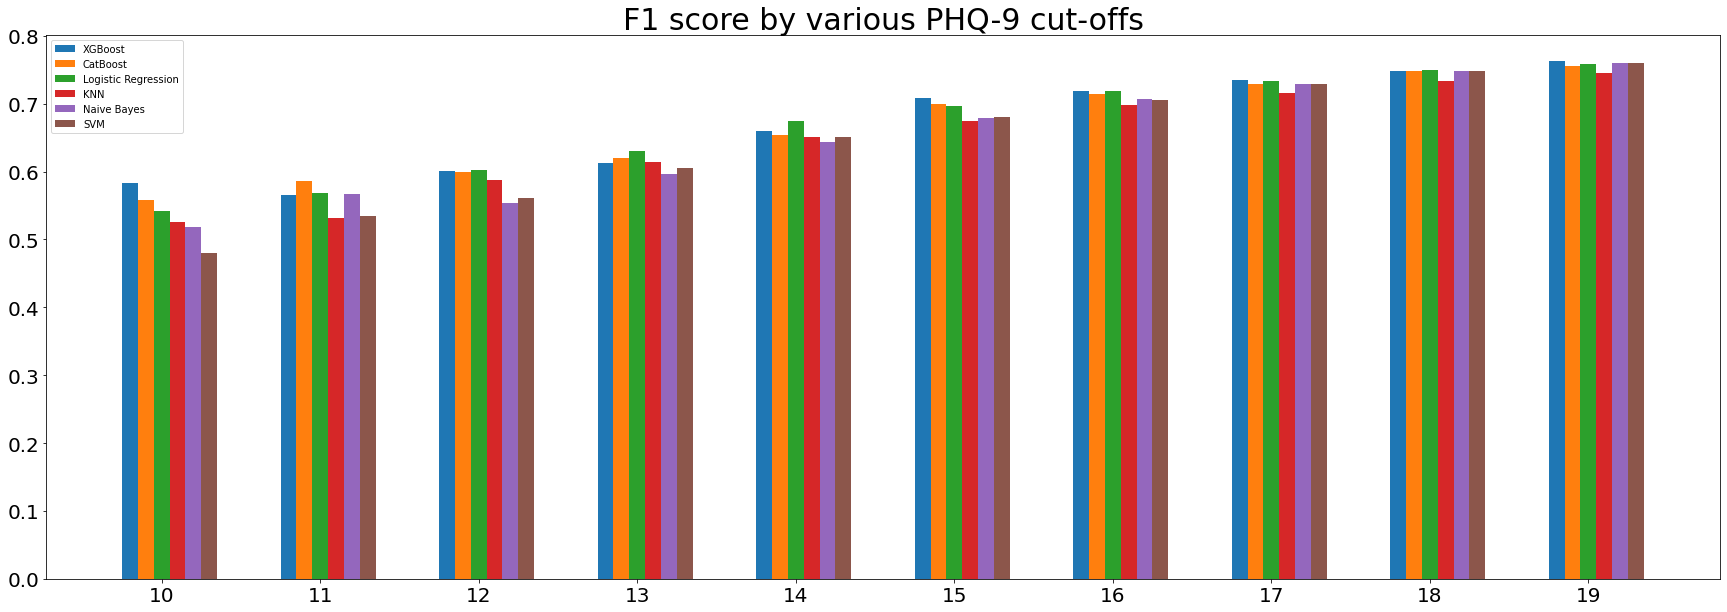

In [75]:
plt.figure(figsize=(30,10))
plt.title('F1 score by various PHQ-9 cut-offs', fontsize=30)
plt.bar(ema_df.index.astype(int)-0.2, ema_df['XGBoost_f1'], 0.1, label='XGBoost')
plt.bar(ema_df.index.astype(int)-0.1, ema_df['LightGBM_f1'], 0.1, label='LightGBM')
plt.bar(ema_df.index.astype(int), ema_df['Logistic_Regression_f1'], 0.1, label='Logistic Regression')
plt.bar(ema_df.index.astype(int)+0.1, ema_df['KNN_f1'], 0.1, label='KNN')
plt.bar(ema_df.index.astype(int)+0.2, ema_df['Naive_Bayes_f1'], 0.1, label='Naive Bayes')
plt.bar(ema_df.index.astype(int)+0.3, ema_df['SVM_f1'], 0.1, label='SVM')

plt.xticks(np.arange(10, 20, 1), size=20)
plt.yticks(size=20)
plt.legend()
plt.show()

In [46]:
ema_df.to_csv('Results_cf_24h.csv')

In [78]:
df_pids = pd.read_excel('IITP_참가자 스크리닝_Data Sharing_220705 (최종).xlsx', sheet_name='STUDY PARTICIPANT(ALL)')
df_pids.index = df_pids['BASIC INFORMATION'] 
df_pids = df_pids.loc[aos_pids]
male_pids = list(df_pids[df_pids['Unnamed: 4']=='남'].index)
female_pids = list(df_pids[df_pids['Unnamed: 4']=='여'].index)

In [79]:
male_pids

[14, 30, 36, 63, 83, 119, 128, 139, 193, 221, 411, 543, 624, 797]

In [80]:
male_results = list()
for df in nor_list:
    results = Train_Gen_Model(df.fillna(0), ema_list[5], male_pids)
    male_results.append(results)

100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


In [81]:
female_results = list()
for df in nor_list:
    results = Train_Gen_Model(df.fillna(0), ema_list[5], female_pids)
    female_results.append(results)

100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


In [82]:
male_df = pd.DataFrame(np.array(male_results), columns=['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1'],
index = ['4h', '8h', '12h', '16h', '20h', '24h'])

female_df = pd.DataFrame(np.array(female_results), columns=['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1'],
index = ['4h', '8h', '12h', '16h', '20h', '24h'])

In [83]:
male_df

,XGBoost_acc,XGBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,Naive_Bayes_acc,Naive_Bayes_f1,SVM_acc,SVM_f1
4h,0.782093,0.729750,0.771043,0.722731,0.801644,0.737307,0.802504,0.737739,0.765139,0.721242,0.802504,0.737739
8h,0.766641,0.725885,0.781557,0.730048,0.800803,0.736879,0.800793,0.736880,0.769945,0.726243,0.802504,0.737739
12h,0.790522,0.742502,0.778624,0.726804,0.798685,0.735810,0.801830,0.737401,0.774566,0.728300,0.802504,0.737739
16h,0.785888,0.734172,0.780709,0.731803,0.799061,0.736003,0.800707,0.736835,0.771250,0.728074,0.802504,0.737739
20h,0.798421,0.744527,0.790526,0.733980,0.799943,0.736446,0.801644,0.737307,0.765012,0.719727,0.802504,0.737739
24h,0.796549,0.742154,0.798309,0.740386,0.802504,0.737739,0.799867,0.736414,0.773118,0.724127,0.802504,0.737739


In [84]:
female_df

,XGBoost_acc,XGBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,Naive_Bayes_acc,Naive_Bayes_f1,SVM_acc,SVM_f1
4h,0.594291,0.640324,0.588807,0.640753,0.606099,0.629310,0.640242,0.637634,0.650753,0.638817,0.669035,0.638221
8h,0.594233,0.630625,0.597949,0.624130,0.585164,0.607500,0.641427,0.637372,0.649811,0.649243,0.663747,0.635558
12h,0.548505,0.590569,0.546507,0.582208,0.589421,0.616546,0.622145,0.641862,0.656792,0.634805,0.647421,0.629444
16h,0.548224,0.592789,0.537095,0.573156,0.600034,0.637266,0.598413,0.635497,0.659955,0.634144,0.639838,0.631741
20h,0.541041,0.581491,0.533861,0.564496,0.556905,0.589614,0.559495,0.612391,0.648130,0.634520,0.622963,0.619645
24h,0.641702,0.680494,0.620040,0.654669,0.639775,0.667974,0.599093,0.649908,0.661907,0.643230,0.653729,0.657597


In [ ]:
['XGBoost_acc', 'XGBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'Naive_Bayes_acc', 'Naive_Bayes_f1', 'SVM_acc', 'SVM_f1']

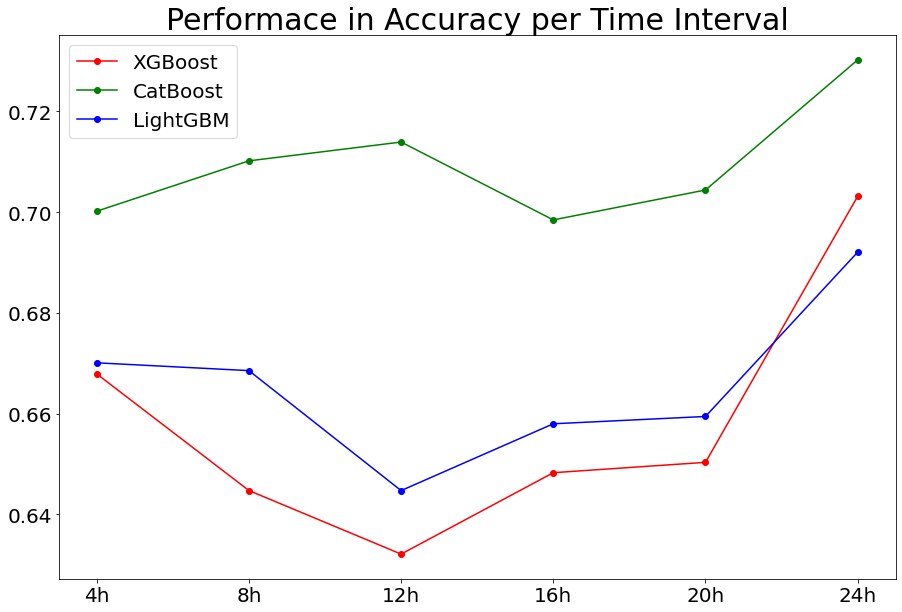

In [41]:
models = ['XGBoost', 'LightGBM', 'Logistic Regression', 'KNN', 'Naive Bayes', 'SVM']

plt.figure(figsize=(15,10))
plt.title('Performace in Accuracy per Time Interval', fontsize=30)
for i in range()

plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], xgc_gen_acc, color='r', marker='o', label='XGBoost')
plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], cbc_gen_acc, color='g', marker='o', label='CatBoost')
plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], lgc_gen_acc, color='b', marker='o', label='LightGBM')

plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

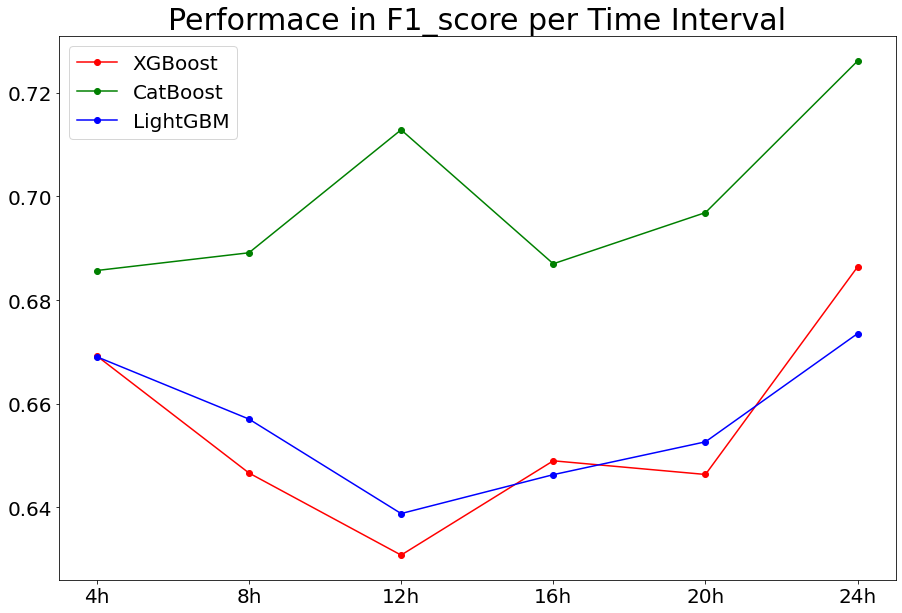

In [42]:
plt.figure(figsize=(15,10))
plt.title('Performace in F1_score per Time Interval', fontsize=30)
plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], xgc_gen_f1, color='r', marker='o', label='XGBoost')
plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], cbc_gen_f1, color='g', marker='o', label='CatBoost')
plt.plot(['4h', '8h', '12h', '16h', '20h', '24h'], lgc_gen_f1, color='b', marker='o', label='LightGBM')

plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

## Personalized Model

Note: XGBoost and CatBoost can't be trained with unique label in supervised learning. LightGBM doesn't matter: why?

In [6]:
aos_pids_unskewed = []
for pid in aos_pids:
    count = aos_ema.loc[pid].depressed.value_counts()
    if len(count) > 1:
        if count[0] > count[1]:
          if int(count[0]/count[1])<10: 
            aos_pids_unskewed.append(pid)
        if count[0] < count[1]:
          if int(count[1]/count[0])<10: 
            aos_pids_unskewed.append(pid)

print(len(aos_pids_unskewed))

11


In [ ]:
aos_X , aos_Y = df.fillna(0), aos_ema
svm_per_acc = list()
svm_per_f1 = list()

for pid in tqdm(aos_pids_unskewed):
    pids = aos_pids.copy()
    pids.remove(pid)
    X = aos_X.loc[pid]
    Y = aos_Y.loc[pid]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle = False) 
    svm_per = SVC(C=0.2)
    svm_per.fit(x_train, y_train)
    svm_pred = svm_per.predict(x_test)
    svm_acc = metrics.accuracy_score(y_test, svm_pred)
    svm_f1 = metrics.f1_score(y_test, svm_pred, average='weighted')
    svm_per_acc.append(svm_acc)
    svm_per_f1.append(svm_f1)

print( np.mean(svm_per_acc), np.mean(svm_per_f1))

In [16]:
import warnings
warnings.filterwarnings(action='ignore')

def Train_Per_Model(aos_X, aos_Y, aos_pids):

    xgc_per_acc = list()
    xgc_per_f1 = list()
    cbc_per_acc = list()
    cbc_per_f1 = list()
    lgc_per_acc = list()
    lgc_per_f1 = list()
    lr_per_acc = list()
    lr_per_f1 = list()
    knn_per_acc = list()
    knn_per_f1 = list()
    nb_per_acc = list()
    nb_per_f1 = list()
    svm_per_acc = list()
    svm_per_f1 = list()

    for pid in tqdm(aos_pids_unskewed):
        pids = aos_pids.copy()
        pids.remove(pid)
        X = aos_X.loc[pid]
        Y = aos_Y.loc[pid]
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle = False) 
        print(len(x_train), len(x_test))

        # GBDT models 
        xgc_per = XGBClassifier(allow_const_label=True)
        xgc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        xgc_pred = xgc_per.predict(x_test)
        xgc_acc = metrics.accuracy_score(y_test, xgc_pred)
        xgc_f1 = metrics.f1_score(y_test, xgc_pred, average='weighted')

        cbc_per = CatBoostClassifier(allow_const_label=True)
        cbc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        cbc_pred = cbc_per.predict(x_test)
        cbc_acc = metrics.accuracy_score(y_test, cbc_pred)
        cbc_f1 = metrics.f1_score(y_test, cbc_pred, average='weighted')

        lgc_per = LGBMClassifier()
        lgc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
        lgc_pred = lgc_per.predict(x_test)
        lgc_acc = metrics.accuracy_score(y_test, lgc_pred)
        lgc_f1 = metrics.f1_score(y_test, lgc_pred, average='weighted')

        # Logistic Regression
        lr_per = LogisticRegression(max_iter = 200, C= 0.1)
        lr_per.fit(x_train, y_train.values.ravel())
        lr_pred = lr_per.predict(x_test)
        lr_acc = metrics.accuracy_score(y_test.values.ravel(), lr_pred)
        lr_f1 = metrics.f1_score(y_test.values.ravel(), lr_pred, average='weighted')
        
        # KNN
        knn_per = KNeighborsClassifier(weights = 'distance')
        knn_per.fit(x_train, y_train)
        knn_pred = knn_per.predict(x_test)
        knn_acc = metrics.accuracy_score(y_test, knn_pred)
        knn_f1 = metrics.f1_score(y_test, knn_pred, average='weighted')
        
        # Categorical Naive Bayes
        nb_per = CategoricalNB()
        nb_per.fit(x_train, y_train)
        nb_pred = nb_per.predict(x_test)
        nb_acc = metrics.accuracy_score(y_test, nb_pred)
        nb_f1 = metrics.f1_score(y_test, nb_pred, average='weighted')

        # SVM
        svm_per = SVC(C=0.2)
        svm_per.fit(x_train, y_train)
        svm_pred = svm_per.predict(x_test)
        svm_acc = metrics.accuracy_score(y_test, svm_pred)
        svm_f1 = metrics.f1_score(y_test, svm_pred, average='weighted')

        xgc_per_acc.append(xgc_acc)
        xgc_per_f1.append(xgc_f1)
        cbc_per_acc.append(cbc_acc)
        cbc_per_f1.append(cbc_f1)
        lgc_per_acc.append(lgc_acc)
        lgc_per_f1.append(lgc_f1)

        lr_per_acc.append(lr_acc)
        lr_per_f1.append(lr_f1)
        knn_per_acc.append(knn_acc)
        knn_per_f1.append(knn_f1)
        nb_per_acc.append(nb_acc)
        nb_per_f1.append(nb_f1)
        svm_per_acc.append(svm_acc)
        svm_per_f1.append(svm_f1)

    return  [np.mean(xgc_per_acc), np.mean(xgc_per_f1), np.mean(cbc_per_acc), np.mean(cbc_per_f1), np.mean(lgc_per_acc), np.mean(lgc_per_f1), 
             np.mean(lr_per_acc), np.mean(lr_per_f1), np.mean(knn_per_acc), np.mean(knn_per_f1), np.mean(nb_per_acc), np.mean(nb_per_f1), np.mean(svm_per_acc), np.mean(svm_per_f1)]

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

df_list = list()
for df in nor_list:
    results = Train_Per_Model(df.fillna(0), aos_ema, aos_pids_unskewed)
    df_list.append(results)

In [53]:
per_df_all = pd.DataFrame(np.array(df_list), columns=['XGBoost_acc', 'XGBoost_f1', 'CatBoost_acc', 'CatBoost_f1', 'LightGBM_acc', 'LightGBM_f1','Logistic_Regression_acc','Logistic_Regression_f1', 'KNN_acc', 'KNN_f1', 'SVM_acc', 'SVM_f1'],
index = ['4h', '8h', '12h', '16h', '20h', '24h'])

In [54]:
per_df_all

,XGBoost_acc,XGBoost_f1,CatBoost_acc,CatBoost_f1,LightGBM_acc,LightGBM_f1,Logistic_Regression_acc,Logistic_Regression_f1,KNN_acc,KNN_f1,SVM_acc,SVM_f1
4h,0.752239,0.751366,0.837046,0.824790,0.740051,0.727103,0.806406,0.763756,0.804620,0.788370,0.834977,0.77649
8h,0.728515,0.738407,0.762954,0.752841,0.736168,0.748253,0.813549,0.769113,0.776049,0.763605,0.834977,0.77649
12h,0.730811,0.739428,0.745096,0.734334,0.750425,0.755985,0.794898,0.755140,0.745096,0.739373,0.834977,0.77649
16h,0.735402,0.739786,0.753033,0.736252,0.688974,0.687611,0.804819,0.765049,0.758702,0.748005,0.834977,0.77649
20h,0.728061,0.728183,0.779620,0.769514,0.720408,0.717164,0.810969,0.770064,0.704337,0.698036,0.834977,0.77649
24h,0.764824,0.763657,0.837528,0.815095,0.792120,0.772037,0.826049,0.784753,0.711763,0.684829,0.834977,0.77649


### Overlapping

In [230]:
xgc_per_acc = list()
xgc_per_f1 = list()
cbc_per_acc = list()
cbc_per_f1 = list()
lgc_per_acc = list()
lgc_per_f1 = list()

for pid in tqdm(aos_pids_unskewed):
    X = df_nor.loc[pid]
    Y = aos_ema.loc[pid]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle = False) 
    
    xgc_per = XGBClassifier()
    xgc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    xgc_pred = xgc_per.predict(x_test)
    xgc_acc = metrics.accuracy_score(y_test, xgc_pred)
    xgc_f1 = metrics.f1_score(y_test, xgc_pred, average='weighted')

    cbc_per = CatBoostClassifier()
    cbc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    cbc_pred = cbc_per.predict(x_test)
    cbc_acc = metrics.accuracy_score(y_test, cbc_pred)
    cbc_f1 = metrics.f1_score(y_test, cbc_pred, average='weighted')

    lgc_per = LGBMClassifier()
    lgc_per.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    lgc_pred = lgc_per.predict(x_test)
    lgc_acc = metrics.accuracy_score(y_test, lgc_pred)
    lgc_f1 = metrics.f1_score(y_test, lgc_pred, average='weighted')

    xgc_per_acc.append(xgc_acc)
    xgc_per_f1.append(xgc_f1)
    cbc_per_acc.append(cbc_acc)
    cbc_per_f1.append(cbc_f1)
    lgc_per_acc.append(lgc_acc)
    lgc_per_f1.append(lgc_f1)

100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


In [250]:
lgc_per_acc_ub = list()
lgc_per_f1_ub = list()

for pid in tqdm(aos_pids):
    X = df_nor.loc[pid]
    Y = aos_ema.loc[pid]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle = False) 
    
    lgc_per_ub = LGBMClassifier()
    lgc_per_ub.fit(x_train, y_train, verbose=False)
    lgc_pred_ub = lgc_per_ub.predict(x_test)
    lgc_acc_ub = metrics.accuracy_score(y_test, lgc_pred_ub)
    lgc_f1_ub = metrics.f1_score(y_test, lgc_pred_ub, average='weighted')

    lgc_per_acc_ub.append(lgc_acc_ub)
    lgc_per_f1_ub.append(lgc_f1_ub)

100%|██████████| 35/35 [00:00<00:00, 45.18it/s]


In [254]:
ol = [np.mean(xgc_gen_acc), np.mean(xgc_gen_f1), np.mean(cbc_gen_acc), np.mean(cbc_gen_f1), np.mean(lgc_gen_acc), np.mean(lgc_gen_f1), 
      np.mean(xgc_per_acc), np.mean(xgc_per_f1), np.mean(cbc_per_acc), np.mean(cbc_per_f1), np.mean(lgc_per_acc), np.mean(lgc_per_f1), np.mean(lgc_per_acc_ub), np.mean(lgc_per_f1_ub)]

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

from xgboost import cv
#params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}


acc_list = list()
f1_list = list()
for dataset in nor_list:
    acc_avg = list()
    f1_avg = list()
    for pid in tqdm(aos_pids):
        X = dataset.loc[pid]
        Y = aos_ema.loc[pid]
        data_dmatrix = xgboost.DMatrix(data=X,label=Y)
        xgc_cv = cv(dtrain=data_dmatrix, nfold=5, num_boost_round=30, early_stopping_rounds=10, metrics="auc")
        pred = xgc.predict(x_test)
        acc = metrics.accuracy_score(y_test, pred)
        f1 = metrics.f1_score(y_test, pred, average='weighted')

        acc_avg.append(acc)
        f1_avg.append(f1)
    
    acc_list.append(np.mean(acc_avg))
    f1_list.append(np.mean(f1_avg))

# Model Interpretation

## Built-in Feature Importance

In [76]:
# XGBoost

xgc_gen_model = list()

for dataset in tqdm(nor_list):    
    #x_train = dataset.loc[aos_pids_unskewed]
    #x_test = dataset.loc[aos_pids_unskewed]
    #y_train = aos_ema.loc[aos_pids_unskewed]
    #y_test = aos_ema.loc[aos_pids_unskewed]
    x_train = dataset
    y_train = aos_ema

    xgc_gen = XGBClassifier()
    xgc_gen.fit(x_train, y_train, verbose=False)  
    xgc_gen_model.append(xgc_gen)

cbc_gen_model = list()

print('----------------------------------XGBoost Generalized Model Done---------------------------------------')

# CatBoost

cbc_gen_model = list()

for dataset in tqdm(nor_list):    
    #x_train = dataset.loc[aos_pids_unskewed]
    #x_test = dataset.loc[aos_pids_unskewed]
    #y_train = aos_ema.loc[aos_pids_unskewed]
    #y_test = aos_ema.loc[aos_pids_unskewed]
    x_train = dataset
    y_train = aos_ema

    cbc_gen = CatBoostClassifier()
    cbc_gen.fit(x_train, y_train, verbose=False)  
    cbc_gen_model.append(cbc_gen)

print('----------------------------------CatBoost Generalized Model Done---------------------------------------')

# LightGBM

lgc_gen_model = list()

for dataset in tqdm(nor_list):    
    #x_train = dataset.loc[aos_pids_unskewed]
    #x_test = dataset.loc[aos_pids_unskewed]
    #y_train = aos_ema.loc[aos_pids_unskewed]
    #y_test = aos_ema.loc[aos_pids_unskewed]
    x_train = dataset
    y_train = aos_ema

    lgc_gen = LGBMClassifier()
    lgc_gen.fit(x_train, y_train, verbose=False)  
    lgc_gen_model.append(lgc_gen)

print('----------------------------------LightGBM Generalized Model Done---------------------------------------')


100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


----------------------------------XGBoost Generalized Model Done---------------------------------------


100%|██████████| 6/6 [00:48<00:00,  8.12s/it]


----------------------------------CatBoost Generalized Model Done---------------------------------------


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

----------------------------------LightGBM Generalized Model Done---------------------------------------


In [264]:
import collections
import pickle


# Create dictionary for each extracted features by time interval by each importance metric

xgc_metric = ["weight", "total_gain", "total_cover", "gain", "cover"]

xgc_gen_imp_dict = {}
hr = 4
for xgc_gen in xgc_gen_model:
    score_list = list()
    for met in xgc_metric:
       score = xgc_gen.get_booster().get_score(importance_type = met)
       score_dict = collections.OrderedDict(sorted(score.items(), key=lambda x: x[1], reverse=True))
       score_list.append(score_dict)
    xgc_gen_imp_dict['{}HR'.format(hr)] = score_list
    hr+=4  

# Save XGBoost Generalized Model Feature Importance Dictionary
with open('xgc_gen_imp_dict.pickle','wb') as fw:
    pickle.dump(xgc_gen_imp_dict, fw)

# Aggregate top N features by each metric
imp_dict = {}
for h in range(4, 25, 4):
    imp_feature = set(list(xgc_gen_imp_dict['{}HR'.format(h)][0].keys())[:30])
    for i in range(1, 5):
        cols = set(list(xgc_gen_imp_dict['{}HR'.format(h)][i].keys())[:30])
        imp_feature = imp_feature & cols
    imp_dict['{}HR'.format(h)] = imp_feature

# Oraganize as DataFrame    
df_fi = pd.DataFrame()
for h in range(4, 25, 4):
    s = imp_dict['{}HR'.format(h)]
    df  = pd.Series(list(s), name='{}HR'.format(h))
    df_fi = pd.concat([df_fi, df], axis=1)


In [291]:
df_fi

,4HR,8HR,12HR,16HR,20HR,24HR
0,location#4HR#max_dist_home,KEYSTROKE#8HR#autocorrect_ratio,appusage#12HR#entertainment_duration,GRAVITY#16HR#Z#max,TYPING#20HR#sum,appusage#24HR#entertainment_duration
1,GRAVITY#4HR#Y#mean,GRAVITY#8HR#Y#std,GRAVITY#12HR#Y#skewness,GRAVITY#16HR#X#mean,appusage#20HR#entertainment_duration,appusage#24HR#social_count
2,KEYSTROKE#4HR#backspace_ratio,KEYSTROKE#8HR#backspace_ratio,KEYSTROKE#12HR#autocorrect_ratio,KEYSTROKE#16HR#backspace_ratio,GRAVITY#20HR#X#std,GRAVITY#24HR#X#skewness
3,GRAVITY#4HR#Z#max,appusage#8HR#communication_count,GRAVITY#12HR#Y#std,SOUND#16HR#PITCH#skewness,GRAVITY#20HR#Z#max,TYPING#24HR#sum
4,appusage#4HR#social_duration,location#8HR#max_dist_home,KEYSTROKE#12HR#interkeyDelay#mean,SCREEN_STATE#16HR#normalized_entropy,SCREEN_STATE#20HR#normalized_entropy,GRAVITY#24HR#Z#max
5,GRAVITY#4HR#X#mean,appusage#8HR#entertainment_duration,GRAVITY#12HR#X#min,GRAVITY#16HR#X#kurtosis,GRAVITY#20HR#X#mean,KEYSTROKE#24HR#autocorrect_accept_ratio
6,appusage#4HR#normalized_entropy,LIGHT#8HR#Brightness_Log#skewness,GRAVITY#12HR#X#std,SOUND#16HR#ENERGY#mean,appusage#20HR#entropy,SOUND#24HR#ENERGY#mean
7,KEYSTROKE#4HR#autocorrect_ratio,appusage#8HR#normalized_entropy,GRAVITY#12HR#X#mean,appusage#16HR#entertainment_duration,SOUND#20HR#ENERGY#std,GRAVITY#24HR#X#kurtosis
8,SOUND#4HR#PITCH#skewness,LIGHT#8HR#Brightness_Log#std,appusage#12HR#entertainment_count,GRAVITY#16HR#X#min,SOUND#20HR#ENERGY#mean,KEYSTROKE#24HR#backspace_ratio
9,SCREEN_STATE#4HR#normalized_entropy,SOUND#8HR#PITCH#skewness,appusage#12HR#normalized_entropy,appusage#16HR#normalized_entropy,KEYSTROKE#20HR#autocorrect_ratio,appusage#24HR#normalized_entropy


In [ ]:
from xgboost import plot_importance
plot_importance

for i in range(1, 7):
    fig = plt.figure(figsize = (30, 80))
    plt.suptitle('XGBoost:Feature Importance: {}HR'.format(4*i), fontsize=30, fontweight ="bold", va='bottom')
    fig.subplots_adjust(top=0.95)

    ax1 = fig.add_subplot(5, 1, 1)
    ax2 = fig.add_subplot(5, 1, 2)
    ax3 = fig.add_subplot(5, 1, 3)
    ax4 = fig.add_subplot(5, 1, 4)
    ax5 = fig.add_subplot(5, 1, 5)

    f1 = plot_importance(xgc_gen_model[i-1], importance_type='weight', ax=ax1)
    f2 = plot_importance(xgc_gen_model[i-1], importance_type='gain', ax=ax2)
    f2 = plot_importance(xgc_gen_model[i-1], importance_type='total_gain', ax=ax3)
    f2 = plot_importance(xgc_gen_model[i-1], importance_type='cover', ax=ax4)
    f3 = plot_importance(xgc_gen_model[i-1], importance_type='total_cover', ax=ax5)

    t1 = ax1.set_title("Feature Importance - Weight", fontsize=20)
    t2 = ax2.set_title("Feature Importance - Split Mean Gain", fontsize=20)
    t3 = ax3.set_title("Feature Importance - Total Gain", fontsize=20)
    t2 = ax4.set_title("Feature Importance - Coverage", fontsize=20)
    t3 = ax5.set_title("Feature Importance - Total Coverage", fontsize=20)

    plt.savefig('XGBoost_FI_{}HR.png'.format(4*i))


# DeepConvLSTM

In [88]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
#import C_pickle as cp
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import sklearn.metrics as metrics

# add the 'src' directory as one where we can import modules
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
#sys.path.append(src_dir)

In [238]:
NB_SENSOR_CHANNELS = 73 # sensor_size
SLIDING_WINDOW_LENGTH = 8 # history_size
SLIDING_WINDOW_STEP = 12 # stride

X_train = np.array().reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS) 
y_train = np.array(train['depressed'].reset_index(drop=True))
Y = np.array(aos_fema['depressed'].reset_index(drop=True))
#Y = np.array(x['depressed']).reshape(-1, SLIDING_WINDOW_LENGTH) for predicting each duplicated label
#Y = x['depressed']
#Y = np.array(ema['depressed'][:-1:12])

print(X.shape, Y.shape)

,sound#4HR#PITCH#mean,sound#4HR#ENERGY#mean,gravity#4HR#X#mean,gravity#4HR#Y#mean,gravity#4HR#Z#mean,wifi#4HR#unique_APs,app#4HR#COMMUNICATION#dur,app#4HR#COMMUNICATION#freq,app#4HR#SOCIAL#dur,app#4HR#SOCIAL#freq,...,app#4HR#kakao#freq,call#4HR#total_freq,call#4HR#conv_freq,call#4HR#conv_dur,call#4HR#MISSED_freq,call#4HR#IN_freq,call#4HR#IN_dur,call#4HR#OUT_freq,call#4HR#OUT_dur,depressed
pid,,,,,,,,,,,,,,,,,,,,,
502,0.000000,0.230057,0.480168,0.755878,0.918309,0.080357,0.015328,0.214286,0.0,0.0,...,0.250,0.214286,0.071429,0.042627,0.4,0.00,0.000000,0.076923,0.085914,1.0
502,0.000000,0.459179,0.556348,0.581949,0.703723,0.035714,0.000000,0.000000,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,1.0
502,0.000000,0.362209,0.510962,0.720482,0.929608,0.071429,0.000000,0.000000,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,1.0
502,0.000000,0.331446,0.439878,0.759906,0.895120,0.062500,0.012717,0.071429,0.0,0.0,...,0.125,0.071429,0.071429,0.010428,0.0,0.00,0.000000,0.076923,0.021018,1.0
502,0.000000,0.774175,0.496105,0.802522,0.834800,0.107143,0.009654,0.142857,0.0,0.0,...,0.000,0.071429,0.071429,0.029638,0.0,0.25,0.029638,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0.000000,0.273708,0.356368,0.029887,0.592095,0.214286,0.000000,0.000000,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0
510,0.000000,0.367891,0.492358,0.374134,0.530554,0.187500,0.000000,0.000000,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0
510,0.306504,0.363121,0.636437,0.672979,0.947514,0.250000,0.149024,0.285714,0.0,0.0,...,0.500,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0


In [202]:
NB_SENSOR_CHANNELS = 82 # sensor_size
SLIDING_WINDOW_LENGTH = 8 # history_size
SLIDING_WINDOW_STEP = 12 # stride

X = np.array(x.drop('depressed', axis=1)).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS) 
Y = np.array(aos_fema['depressed'].reset_index(drop=True))
#Y = np.array(x['depressed']).reshape(-1, SLIDING_WINDOW_LENGTH) for predicting each duplicated label
#Y = x['depressed']
#Y = np.array(ema['depressed'][:-1:12])

print(X.shape, Y.shape)

(1935, 8, 82) (1935,)


In [209]:
aos_fema.index

Int64Index([128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
            ...
            318, 318, 318, 318, 318, 318, 318, 318, 318, 318],
           dtype='int64', name='pid', length=1935)

In [204]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle = False) #random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, shuffle = False)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1305, 8, 82) (194, 8, 82)
(1305,) (194,)


In [205]:
class HARModel(nn.Module):
    
    def __init__(self, n_hidden=64, n_layers=1, n_filters=32, n_classes=2, filter_size=2, drop_prob=0.5):
        super(HARModel, self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_filters = n_filters
        self.n_classes = n_classes
        self.filter_size = filter_size
             
        self.conv1 = nn.Conv1d(NB_SENSOR_CHANNELS, n_filters, filter_size)
        self.conv2 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv3 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv4 = nn.Conv1d(n_filters, n_filters, filter_size)
        
        self.lstm1  = nn.LSTM(n_filters, n_hidden, n_layers)
        self.lstm2  = nn.LSTM(n_hidden, n_hidden, n_layers)
      # self.lstm3  = nn.LSTM(n_hidden, n_hidden*2, n_layers)

        self.fc = nn.Linear(n_hidden, n_classes)
       #self.fc = nn.Softmax(dim=-1)

        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, x, hidden, batch_size):
        
        x = x.contiguous().view(-1, NB_SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)
        x = x.to(torch.float32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
       
        x = x.view(4, -1, self.n_filters)
        x, hidden = self.lstm1(x, hidden)
        x, hidden = self.lstm2(x, hidden)
    #   x, hidden = self.lstm3(x, hidden)
        
        x = x.contiguous().view(-1, self.n_hidden)
        x = self.dropout(x)
        x = self.fc(x)
        
        out = x.view(batch_size, -1, self.n_classes)[:,-1,:]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
    
net = HARModel()

def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif type(m) == nn.Conv1d or type(m) == nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0)
net.apply(init_weights) 

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [197]:
## check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [206]:
def train(net, epochs=30, batch_size=20, lr=0.001):
    
    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.1, weight_decay=1e-4)
   #opt = torch.optim.RMSprop(net.parameters(), lr=lr, momentum=0.3, weight_decay=1e-4)
   #opt = torch.optim.Adadelta(net.parameters(), lr=lr, rho=0.9, eps=1e-04, weight_decay=0)
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss() # of class: 2
    torch.autograd.set_detect_anomaly(True)

    trainloss = list()
    valloss = list()
    f1_score = list()

    if(train_on_gpu):
        net.cuda()
     
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)         
        train_losses = []    
        net.train()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            x, y = batch

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            
            # zero accumulated gradients
            opt.zero_grad()   
            
            # get the output from the model
            output, h = net(inputs, h, batch_size)
            
            loss = criterion(output, targets.long())
            train_losses.append(loss.item())
        
            loss.backward()
            opt.step()
            
        val_h = net.init_hidden(batch_size)
        val_losses = []
        accuracy=0
        f1score=0
        net.eval()
        with torch.no_grad():
            for batch in iterate_minibatches(X_test, y_test, batch_size):
                x, y = batch     

                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()
                    
                output, val_h= net(inputs, val_h, batch_size)

                val_loss = criterion(output, targets.long())
                val_losses.append(val_loss.item())
                top_p, top_class = output.topk(1, dim=1)
                equals = top_class == targets.view(*top_class.shape).long()
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                f1score += metrics.f1_score(top_class.cpu(), targets.view(*top_class.shape).long().cpu(), average='weighted')

        
        trainloss.append(np.mean(train_losses))
        valloss.append(np.mean(val_losses))
        f1_score.append(f1score/(len(X_test)//batch_size))

        net.train() # reset to train mode after iterationg through validation data
                
        print("Epoch: {}/{}...".format(e+1, epochs),
        "Train Loss: {:.4f}...".format(np.mean(train_losses)),
        "Val Loss: {:.4f}...".format(np.mean(val_losses)),
        "Val Acc: {:.4f}...".format(accuracy/(len(X_test)//batch_size)),
        "F1-Score: {:.4f}...".format(f1score/(len(X_test)//batch_size)))

    return trainloss, valloss, f1_score

#train(net)

In [275]:
X = x.copy()

In [283]:
def train(net, epochs=10, batch_size=20, lr=0.01):
    
   #opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.1, weight_decay=1e-4)
   #opt = torch.optim.RMSprop(net.parameters(), lr=lr, momentum=0.3, weight_decay=1e-4)
    opt = torch.optim.Adadelta(net.parameters(), lr=lr, rho=0.9, eps=1e-04, weight_decay=0)
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss() # of class: 2
    torch.autograd.set_detect_anomaly(True)

    trainloss = list()
    valloss = list()
    f1_score = list()

    if(train_on_gpu):
        net.cuda()
     
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)         
        train_losses = []    
        net.train()

        for p in pidlist:
            pid = pidlist.copy()
            pid.remove(p)
            X_train = np.array(X.drop('depressed', axis=1).loc[pid]).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS).astype(np.float32) 
            X_test = np.array(X.drop('depressed', axis=1).loc[p]).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS).astype(np.float32)
            y_train = np.array(aos_fema['depressed'].loc[pid]).astype(np.float32)
            y_test = np.array(aos_fema['depressed'].loc[p].astype(np.float32))

            for batch in iterate_minibatches(X_train, y_train, batch_size):
                x, y = batch

                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = tuple([each.data for each in h])
                
                # zero accumulated gradients
                opt.zero_grad()   
                
                # get the output from the model
                output, h = net(inputs, h, batch_size)
                
                loss = criterion(output, targets.long())
                train_losses.append(loss.item())
            
                loss.backward()
                opt.step()
                
            val_h = net.init_hidden(batch_size)
            val_losses = []
            accuracy=0
            f1score=0
            net.eval()
            with torch.no_grad():
                for batch in iterate_minibatches(X_test, y_test, batch_size):
                    x, y = batch     

                    inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                    val_h = tuple([each.data for each in val_h])

                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()
                        
                    output, val_h= net(inputs, val_h, batch_size)

                    val_loss = criterion(output, targets.long())
                    val_losses.append(val_loss.item())
                    top_p, top_class = output.topk(1, dim=1)
                    equals = top_class == targets.view(*top_class.shape).long()
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    f1score += metrics.f1_score(top_class.cpu(), targets.view(*top_class.shape).long().cpu(), average='weighted')

        
        trainloss.append(np.mean(train_losses))
        valloss.append(np.mean(val_losses))
        f1_score.append(f1score/(len(X_test)//batch_size))

        net.train() # reset to train mode after iterationg through validation data
                
        print("Epoch: {}/{}...".format(e+1, epochs),
        "Train Loss: {:.4f}...".format(np.mean(train_losses)),
        "Val Loss: {:.4f}...".format(np.mean(val_losses)),
        "Val Acc: {:.4f}...".format(accuracy/(len(X_test)//batch_size)),
        "F1-Score: {:.4f}...".format(f1score/(len(X_test)//batch_size)))

    return trainloss, valloss, f1_score

In [284]:
t =  train(net)

Epoch: 1/10... Train Loss: 0.6872... Val Loss: 0.6089... Val Acc: 0.9125... F1-Score: 0.9530...
Epoch: 2/10... Train Loss: 0.6873... Val Loss: 0.6146... Val Acc: 0.9000... F1-Score: 0.9470...
Epoch: 3/10... Train Loss: 0.6873... Val Loss: 0.6129... Val Acc: 0.9000... F1-Score: 0.9470...
Epoch: 4/10... Train Loss: 0.6872... Val Loss: 0.6126... Val Acc: 0.9000... F1-Score: 0.9462...
Epoch: 5/10... Train Loss: 0.6872... Val Loss: 0.6113... Val Acc: 0.9000... F1-Score: 0.9470...
Epoch: 6/10... Train Loss: 0.6871... Val Loss: 0.6125... Val Acc: 0.9000... F1-Score: 0.9459...
Epoch: 7/10... Train Loss: 0.6872... Val Loss: 0.6116... Val Acc: 0.9000... F1-Score: 0.9459...
Epoch: 8/10... Train Loss: 0.6873... Val Loss: 0.6123... Val Acc: 0.9000... F1-Score: 0.9463...
Epoch: 9/10... Train Loss: 0.6871... Val Loss: 0.6088... Val Acc: 0.9125... F1-Score: 0.9530...
Epoch: 10/10... Train Loss: 0.6872... Val Loss: 0.6108... Val Acc: 0.9000... F1-Score: 0.9447...


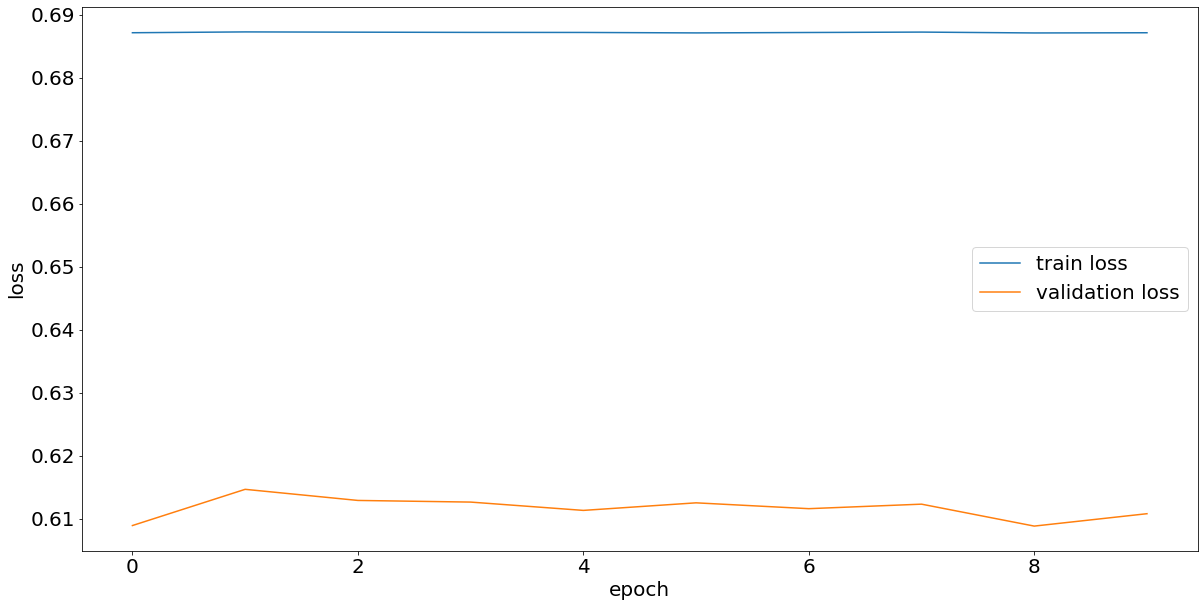

In [285]:
# Adadelta optimizer
plt.figure(figsize=(20, 10))
plt.xlabel('epoch', size=20)
plt.ylabel('loss', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.plot(t[0])
plt.plot(t[1])
plt.legend(['train loss', 'validation loss'], fontsize=20)

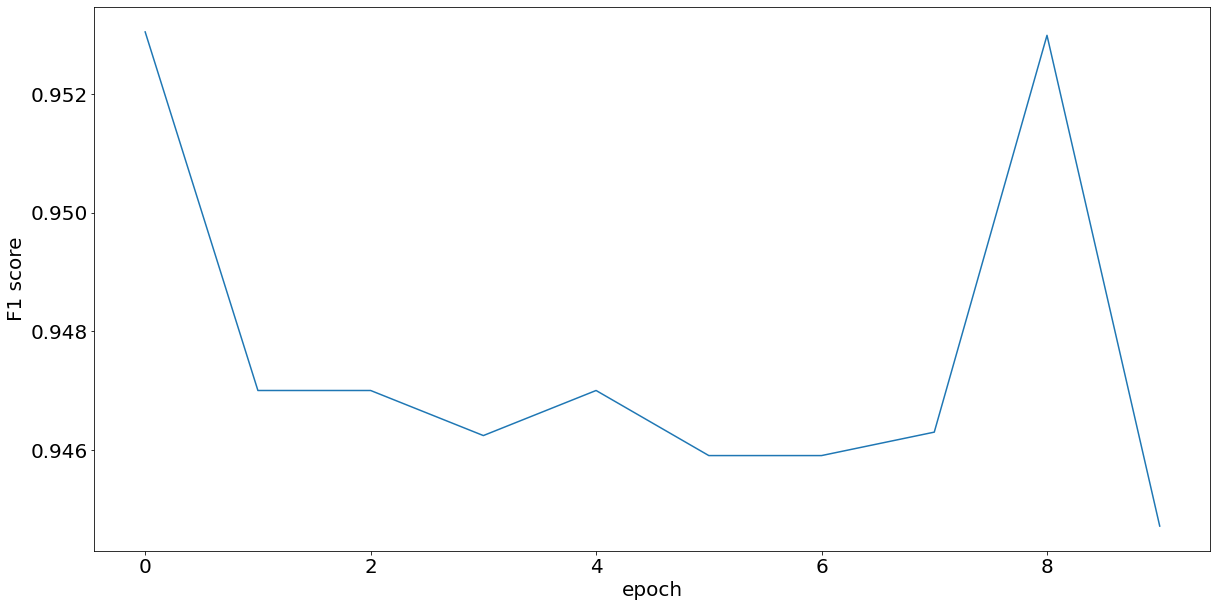

In [286]:
plt.figure(figsize=(20, 10))
plt.xlabel('epoch', size=20)
plt.ylabel('F1 score', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.plot(t[2])

In [282]:
print(np.min(t[0]), np.min(t[1]),np.max(t[2]) ) 

0.6900939593712488 0.6795516312122345 0.8700204290091931


In [ ]:
X_train = np.array(x.drop('depressed', axis=1).loc[128:742]).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS).astype(np.float32) 
X_test = np.array(x.drop('depressed', axis=1).loc[502:510]).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS).astype(np.float32)
y_train = np.array(aos_fema['depressed'].loc[128:742]).astype(np.float32)
y_test = np.array(aos_fema['depressed'].loc[502:510].astype(np.float32))

In [ ]:
X = np.array(x.drop('depressed', axis=1)).reshape(-1,SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS) 
Y = np.array(aos_fema['depressed'].reset_index(drop=True))

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [ ]:
# SGD optimizer
plt.figure(figsize=(20, 10))
plt.xlabel('epoch', size=20)
plt.ylabel('loss', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.plot(t[0])
plt.plot(t[1])
plt.legend(['train loss', 'validation loss'], fontsize=20)

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('epoch', size=20)
plt.ylabel('F1 score', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.plot(t[2])

In [ ]:
print(np.min(t[0]), np.min(t[1]),np.max(t[2]) ) 

## 